 # Skin Diasese detection test

In [33]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [34]:
tf.__version__

'2.10.0'

## Processing the training set

In [35]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9,1.1],
    fill_mode='nearest'
)
training_set = train_datagen.flow_from_directory(
    'C:/Users/User/Downloads/6_skin_diseases/kaggle/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
)

Found 30909 images belonging to 6 classes.


## Preprocessing the test set

In [36]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    'C:/Users/User/Downloads/6_skin_diseases/kaggle/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
)

Found 3928 images belonging to 6 classes.


## Building the CNN

In [37]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 3. Load Pretrained MobileNetV2 (Exclude top layers)
base_model = MobileNetV2(input_shape=(128, 128, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:100]:  # freeze only first 100 layers
    layer.trainable = False



# 4. Add Custom Classification Head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(6, activation='softmax')
])


# 5. Compile Model
model.compile(optimizer=Adam(1e-5),  # use a smaller learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 6. Train Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

model.fit(training_set,
          validation_data=test_set,
          epochs=20,
          callbacks=callbacks,
          verbose=1)
# 7. Save the Model


Epoch 1/20
966/966 [==============================] - 439s 451ms/step - loss: 1.4836 - accuracy: 0.4072 - val_loss: 1.1975 - val_accuracy: 0.5071 - lr: 1.0000e-05
Epoch 2/20
966/966 [==============================] - 437s 452ms/step - loss: 1.2016 - accuracy: 0.5116 - val_loss: 1.0127 - val_accuracy: 0.5876 - lr: 1.0000e-05
Epoch 3/20
966/966 [==============================] - 440s 456ms/step - loss: 1.1048 - accuracy: 0.5553 - val_loss: 0.9487 - val_accuracy: 0.6184 - lr: 1.0000e-05
Epoch 4/20
966/966 [==============================] - 440s 455ms/step - loss: 1.0340 - accuracy: 0.5858 - val_loss: 0.9043 - val_accuracy: 0.6382 - lr: 1.0000e-05
Epoch 5/20
966/966 [==============================] - 437s 452ms/step - loss: 0.9754 - accuracy: 0.6162 - val_loss: 0.8763 - val_accuracy: 0.6499 - lr: 1.0000e-05
Epoch 6/20
966/966 [==============================] - 433s 448ms/step - loss: 0.9377 - accuracy: 0.6354 - val_loss: 0.8454 - val_accuracy: 0.6629 - lr: 1.0000e-05
Epoch 7/20
966/966 [==

1/1 [==============================] - 2s 2s/step


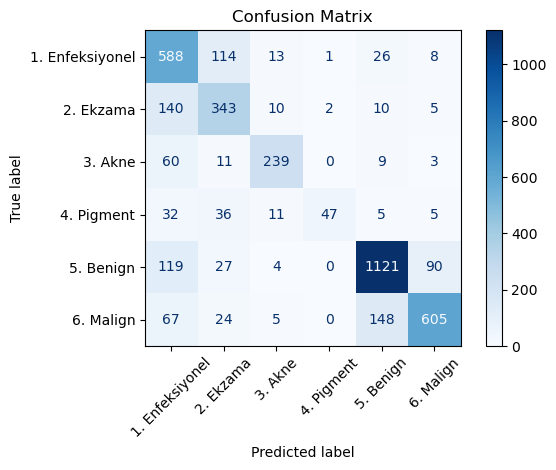

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Get true labels and predictions
Y_true = []
Y_pred = []

# Go through test batches and collect predictions
for i in range(len(test_set)):
    x_batch, y_batch = test_set[i]
    y_pred_batch = model.predict(x_batch)
    
    Y_true.extend(np.argmax(y_batch, axis=1))
    Y_pred.extend(np.argmax(y_pred_batch, axis=1))

    if (i + 1) * test_set.batch_size >= test_set.samples:
        break  # Stop if we've processed all test data

# 2. Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
labels = list(test_set.class_indices.keys())  # Class names

# 3. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


Found 3923 images belonging to 6 classes.
62/62 [==============================] - 52s 843ms/step


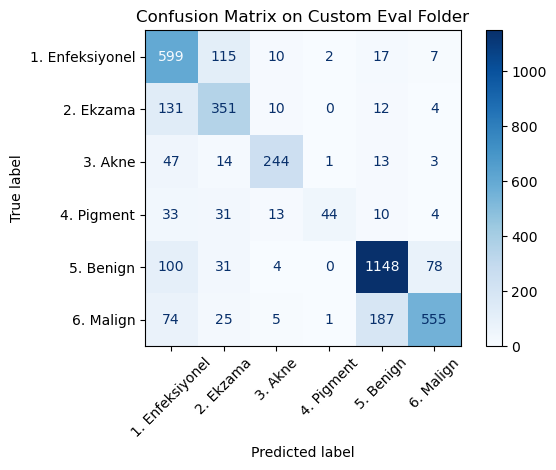

In [50]:
eval_datagen = ImageDataGenerator(rescale=1./255)

eval_set = eval_datagen.flow_from_directory(
    'C:/Users/User/Downloads/6_skin_diseases/kaggle/val',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Important: keep order for correct confusion matrix
)
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_true = eval_set.classes
y_pred_probs = model.predict(eval_set)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names
class_labels = list(eval_set.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Custom Eval Folder")
plt.tight_layout()
plt.show()


In [39]:
model.save('mobilenet_skin_model_77_accuracy_20_epochs.h5')

In [49]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array  # ✅ Modern import

# Load and preprocess the image
test_image = load_img('C:/Users/User/Downloads/6_skin_diseases/kaggle/single_test/pg1.jpg', target_size=(128, 128))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# Predict using the CNN model
result = model.predict(test_image)

# Define class labels in the same order as training_set.class_indices
class_labels = [
    "Enfeksiyonel",
    "Ekzama",
    "Akne",
    "Pigment",
    "Benign",
    "Malign"
]

# Get the predicted class index
predicted_index = np.argmax(result[0])
prediction = class_labels[predicted_index]

print("Predicted class:", prediction)

1/1 [==============================] - 0s 26ms/step
Predicted class: Enfeksiyonel


In [16]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])


In [17]:
cnn.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [18]:
cnn.fit(x = training_set, validation_data = test_set, epochs=25, verbose=1)

Epoch 1/25
966/966 [==============================] - 515s 532ms/step - loss: 1.6508 - accuracy: 0.3706 - val_loss: 1.4085 - val_accuracy: 0.4282
Epoch 2/25
 60/966 [>.............................] - ETA: 7:14 - loss: 1.4072 - accuracy: 0.4026

KeyboardInterrupt: 

In [ ]:
cnn.save('6_skin_disease_model.h5')  # or .keras

In [ ]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array  # ✅ Modern import

# Load and preprocess the image
test_image = load_img('C:/Users/User/Downloads/6_skin_diseases/kaggle/single_test/ezm.jpg', target_size=(128, 128))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# Predict using the CNN model
result = cnn.predict(test_image)

# Define class labels in the same order as training_set.class_indices
class_labels = [
    "Enfeksiyonel",
    "Ekzama",
    "Akne",
    "Pigment",
    "Benign",
    "Malign"
]

# Get the predicted class index
predicted_index = np.argmax(result[0])
prediction = class_labels[predicted_index]

print("Predicted class:", prediction)


1/1 [==============================] - 0s 119ms/step
Predicted class: Benign
